In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
savefigs = False

**Outputs required:**
- labour wait time
- truck wait time
- total no. trucks offloaded

# 1. Input probability distributions

sum(offload_duration_prob) = 1.0


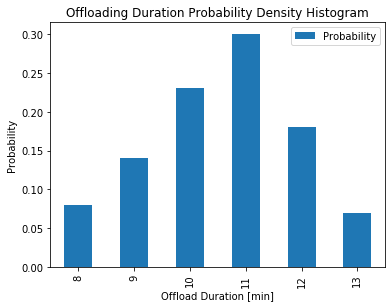

In [3]:
duration_distr = pd.DataFrame(
    [
        [ 8, 0.08],
        [ 9, 0.14],
        [10, 0.23],
        [11, 0.30],
        [12, 0.18],
        [13, 0.07]
    ], 
    columns=['Duration', 'Probability']
)
print(f'sum(offload_duration_prob) = {duration_distr["Probability"].sum()}')
      
fig, ax = plt.subplots(figsize=(6, 4.5))
duration_distr.set_index('Duration').plot(
    kind='bar', 
    title='Offloading Duration Probability Density Histogram', 
    ax=ax
)
ax.set_xlabel('Offload Duration [min]')
ax.set_ylabel('Probability')
plt.show()

if savefigs:
    fig.savefig('figs/offload_prob.png', dpi=800)

sum(arrival_distr) = 1.0


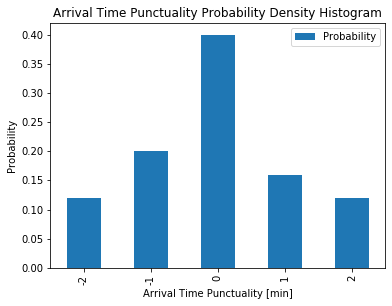

In [4]:
arrival_distr = pd.DataFrame(
    [
        [-2, 0.12],
        [-1, 0.20],
        [ 0, 0.40],
        [ 1, 0.16],
        [ 2, 0.12]
    ], 
    columns=['Arrival', 'Probability']
)
print(f'sum(arrival_distr) = {arrival_distr["Probability"].sum()}')
      
fig, ax = plt.subplots(figsize=(6, 4.5))
arrival_distr.set_index('Arrival').plot(
    kind='bar', 
    title='Arrival Time Punctuality Probability Density Histogram', 
    ax=ax
)
ax.set_xlabel('Arrival Time Punctuality [min]')
ax.set_ylabel('Probability')
plt.show()

if savefigs:
    fig.savefig('figs/arrival_prob.png', dpi=800)

# 2. Function to return random offloading time according to probability distribution

In [5]:
def get_duration(n=1, values=duration_distr['Duration'].values, prob=duration_distr['Probability'].values):
    return np.random.choice(values, n, p=prob)

In [6]:
def get_arrival(n=1, values=arrival_distr['Arrival'].values, prob=arrival_distr['Probability'].values):
    return np.random.choice(values, n, p=prob)

**Check function works:**

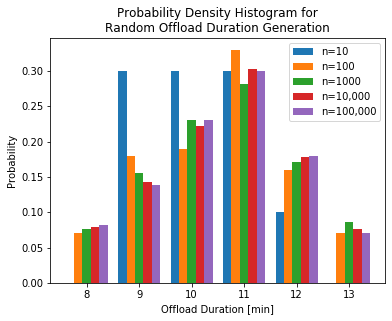

In [7]:
durations = [
    get_duration(10), 
    get_duration(100), 
    get_duration(1000),
    get_duration(10000),
    get_duration(100000),
]

fig, ax = plt.subplots(figsize=(6, 4.5))
ax.hist(
    durations, 
    bins=np.arange(7.5, 13.5+1, 1), 
    density=True
)
ax.set_title('Probability Density Histogram for\nRandom Offload Duration Generation')
ax.set_xlabel('Offload Duration [min]')
ax.set_ylabel('Probability')
ax.legend(['n=10', 'n=100', 'n=1000', 'n=10,000', 'n=100,000'])
plt.show()

if savefigs:
    fig.savefig('figs/offload_duration_distribution.png', dpi=800)

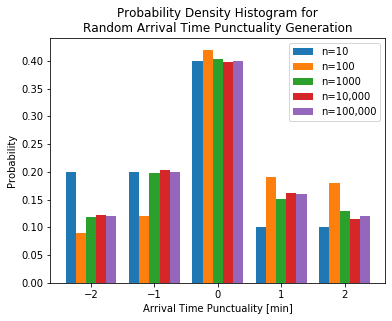

In [8]:
arrival = [
    get_arrival(10), 
    get_arrival(100), 
    get_arrival(1000),
    get_arrival(10000),
    get_arrival(100000),
]

fig, ax = plt.subplots(figsize=(6, 4.5))
ax.hist(
    arrival, 
    bins=np.arange(-2.5, 2.5+1, 1), 
    density=True
)
ax.set_title('Probability Density Histogram for\nRandom Arrival Time Punctuality Generation')
ax.set_xlabel('Arrival Time Punctuality [min]')
ax.set_ylabel('Probability')
ax.legend(['n=10', 'n=100', 'n=1000', 'n=10,000', 'n=100,000'])
plt.show()

if savefigs:
    fig.savefig('figs/arrival_punctuality_distribution.png', dpi=800)

# Initialise global variables

In [9]:
simulation_period = 180 # [min] 3h
scheduled_interval = 10 # [min]
n_trucks_sim = int(np.ceil((simulation_period - arrival_distr['Arrival'].min())/scheduled_interval)) # max no. trucks possible

scheduled_arrival = pd.Series(np.arange(0, n_trucks_sim*scheduled_interval, scheduled_interval), name='arrival_scheduled')
print(f'No. trucks simulated: {n_trucks_sim}')

No. trucks simulated: 19


# (test) Simulate single goods receipt session

In [10]:
df = pd.DataFrame(scheduled_arrival)
df['offload_duration'] = get_duration(n_trucks_sim)
df['arrival_actual'] = df['arrival_scheduled'] + get_arrival(n_trucks_sim)
df

,arrival_scheduled,offload_duration,arrival_actual
0,0,10,-1
1,10,9,10
2,20,12,20
3,30,9,32
4,40,12,40
5,50,9,50
6,60,11,60
7,70,10,71
8,80,10,82
9,90,12,90


In [11]:
start_time = []
finish_time = []
wait_time_labour = []
for i, row in df.iterrows():
    if (i > 0):
        start_time.append(np.max([row['arrival_actual'], finish_time[i-1]]))
        wait_time_labour.append(start_time[i] - finish_time[i-1])
    else:
        start_time.append(row['arrival_actual'])
        wait_time_labour.append(0)
           
    finish_time.append(start_time[i] + row['offload_duration'])
df['start_time'] = start_time
df['finish_time'] = finish_time
df['wait_time_labour'] = wait_time_labour
df['wait_time_truck'] = df['start_time'] - df['arrival_actual']
df

,arrival_scheduled,offload_duration,arrival_actual,start_time,finish_time,wait_time_labour,wait_time_truck
0,0,10,-1,-1,9,0,0
1,10,9,10,10,19,1,0
2,20,12,20,20,32,1,0
3,30,9,32,32,41,0,0
4,40,12,40,41,53,0,1
5,50,9,50,53,62,0,3
6,60,11,60,62,73,0,2
7,70,10,71,73,83,0,2
8,80,10,82,83,93,0,1
9,90,12,90,93,105,0,3


In [12]:
total_wait_time_labour = df['wait_time_labour'].sum()
total_wait_time_truck = df['wait_time_truck'].sum()
no_trucks_complete = (df['finish_time'] < simulation_period).sum()
print(f'total_wait_time_labour: {total_wait_time_labour:4d} min')
print(f'total_wait_time_truck:  {total_wait_time_truck:4d} min')
print(f'no_trucks_complete:     {no_trucks_complete:4d} trucks')

total_wait_time_labour:    2 min
total_wait_time_truck:    64 min
no_trucks_complete:       17 trucks


In [13]:
idx_last = df[df['start_time'] < simulation_period]['start_time'].idxmax()

In [14]:
partial_truck_completion = (
    (simulation_period - df.loc[idx_last,'start_time'])
    /(df.loc[idx_last,'finish_time'] - df.loc[idx_last,'start_time'])
)
partial_truck_wait_time_truck = partial_truck_completion * df.loc[idx_last,'wait_time_truck']
partial_truck_wait_time_labour = partial_truck_completion * df.loc[idx_last,'wait_time_labour']

In [15]:
df = df.loc[:idx_last-1,]
df

,arrival_scheduled,offload_duration,arrival_actual,start_time,finish_time,wait_time_labour,wait_time_truck
0,0,10,-1,-1,9,0,0
1,10,9,10,10,19,1,0
2,20,12,20,20,32,1,0
3,30,9,32,32,41,0,0
4,40,12,40,41,53,0,1
5,50,9,50,53,62,0,3
6,60,11,60,62,73,0,2
7,70,10,71,73,83,0,2
8,80,10,82,83,93,0,1
9,90,12,90,93,105,0,3


In [16]:
total_wait_time_labour = df['wait_time_labour'].sum() + partial_truck_wait_time_truck
total_wait_time_truck = df['wait_time_truck'].sum() + partial_truck_wait_time_labour
no_trucks_complete = (df['finish_time'] < simulation_period).sum() + partial_truck_completion

print(f'total_wait_time_labour: {total_wait_time_labour:4.0f} min')
print(f'total_wait_time_truck:  {total_wait_time_truck:4.0f} min')
print(f'no_trucks_complete:     {no_trucks_complete:4.1f} trucks')

total_wait_time_labour:    4 min
total_wait_time_truck:    54 min
no_trucks_complete:     17.5 trucks


# Montecarlo simulation

**Simulation parameters**

In [17]:
n_monte = 1000 # no. simulation loops

simulation_period = 180 # [min] 3h
scheduled_interval = 10 # [min]

n_trucks_sim = int(np.ceil((simulation_period - arrival_distr['Arrival'].min())/scheduled_interval)) # max no. trucks possible

scheduled_arrival = pd.Series(np.arange(0, n_trucks_sim*scheduled_interval, scheduled_interval), name='arrival_scheduled')

print(f'No. trucks simulated: {n_trucks_sim}')

No. trucks simulated: 19


**Run simulation**

In [18]:
results = {
    'total_wait_time_labour': np.zeros(n_monte),
    'total_wait_time_truck': np.zeros(n_monte),
    'no_trucks_complete': np.zeros(n_monte)
}

for j in range(0, n_monte):
    df = pd.DataFrame(scheduled_arrival)
    df['offload_duration'] = get_duration(n_trucks_sim)
    df['arrival_actual'] = df['arrival_scheduled'] + get_arrival(n_trucks_sim)

    start_time = []
    finish_time = []
    wait_time_labour = []
    for i, row in df.iterrows():
        if (i > 0):
            start_time.append(np.max([row['arrival_actual'], finish_time[i-1]]))
            wait_time_labour.append(start_time[i] - finish_time[i-1])
        else:
            start_time.append(row['arrival_actual'])
            wait_time_labour.append(0)

        finish_time.append(start_time[i] + row['offload_duration'])
    df['start_time'] = start_time
    df['finish_time'] = finish_time
    df['wait_time_labour'] = wait_time_labour
    df['wait_time_truck'] = df['start_time'] - df['arrival_actual']

    total_wait_time_labour = df['wait_time_labour'].sum()
    total_wait_time_truck = df['wait_time_truck'].sum()
    no_trucks_complete = (df['finish_time'] < simulation_period).sum()

    idx_last = df[df['start_time'] < simulation_period]['start_time'].idxmax()

    partial_truck_completion = (
        (simulation_period - df.loc[idx_last,'start_time'])
        /(df.loc[idx_last,'finish_time'] - df.loc[idx_last,'start_time'])
    )
    partial_truck_wait_time_truck = partial_truck_completion * df.loc[idx_last,'wait_time_truck']
    partial_truck_wait_time_labour = partial_truck_completion * df.loc[idx_last,'wait_time_labour']

    df = df.loc[:idx_last-1,]

    results['total_wait_time_labour'][j] = df['wait_time_labour'].sum() + partial_truck_wait_time_truck
    results['total_wait_time_truck'][j] = df['wait_time_truck'].sum() + partial_truck_wait_time_labour
    results['no_trucks_complete'][j] = (df['finish_time'] < simulation_period).sum() + partial_truck_completion

In [19]:
results = pd.DataFrame(results)

In [23]:
results

,total_wait_time_labour,total_wait_time_truck,no_trucks_complete
0,11.000000,46.0,17.000000
1,4.500000,23.0,17.700000
2,13.666667,59.0,16.888889
3,9.000000,69.0,17.000000
4,9.090909,98.0,16.909091
...,...,...,...
995,6.545455,117.0,16.363636
996,8.333333,101.0,16.833333
997,10.818182,114.0,16.454545
998,10.000000,51.0,17.000000


In [20]:
# results.hist(bins='doane', figsize=(8,6))
# plt.tight_layout()
# plt.show()

In [21]:
results.describe()

,total_wait_time_labour,total_wait_time_truck,no_trucks_complete
count,1000.000000,1000.000000,1000.000000
mean,7.341146,89.319394,16.882234
std,4.295813,35.291429,0.468103
min,0.000000,14.000000,15.250000
25%,3.555556,62.000000,16.600000
50%,7.550505,88.000000,16.900000
75%,10.000000,114.000000,17.200000
max,23.000000,201.000000,18.250000


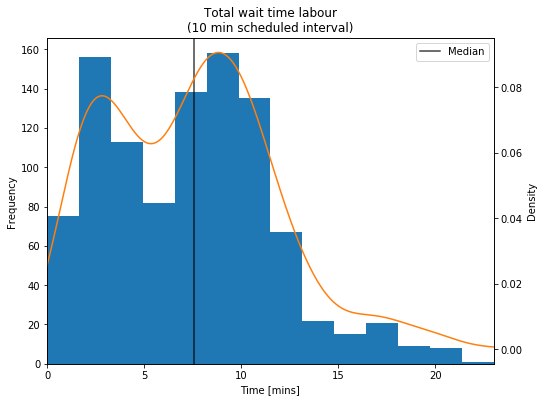

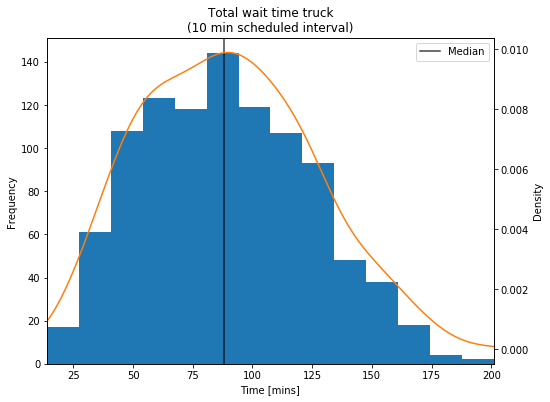

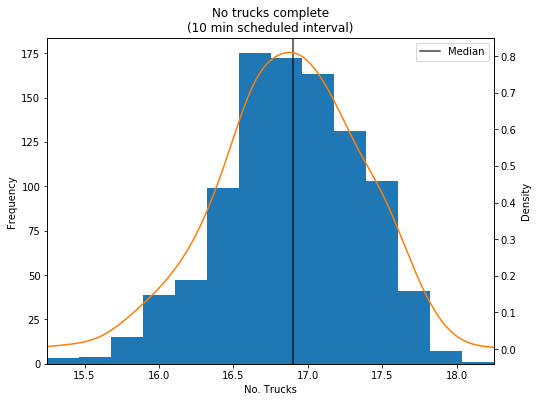

In [22]:
fig = {}
ax = {}

for i, column in enumerate(results):
    fig[i], ax[i] = plt.subplots(figsize=(8,6))
    results[column].hist(ax=ax[i], bins='doane')
    results[column].plot.kde(ax=ax[i], secondary_y=True, bw_method=0.3)
    
    ax[i].axvline(results[column].median(), c='k', alpha=0.75, label='Median')
    
    ax[i].set_xlim([results[column].min(), results[column].max()])
    ax[i].set(
        title=column.replace('_', ' ').capitalize() + f'\n({scheduled_interval} min scheduled interval)', 
        xlabel='Time [mins]', 
        ylabel='Frequency'
    )
    if column == 'no_trucks_complete':
        ax[i].set(xlabel='No. Trucks')
        
    ax[i].right_ax.set_ylabel('Density')
    ax[i].legend()
    
    if savefigs:
        fig[i].savefig(f'figs/{column}_{scheduled_interval}min.png', dpi=800)
    plt.show()